In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from pathlib import Path
from tqdm import tqdm
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.metrics import median_absolute_error

import arviz as az
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class MixedEffects(Baseline):
    LINK = "MixedEffects"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_baseline = 1
        n_feature0 = 2
        # n_delta = 1

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
            global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

            global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(1))
            global_sigma_l_baseline = numpyro.sample("global_sigma_l_baseline", dist.HalfNormal(100))
            global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(5))

            global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
            global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

            global_sigma_p_baseline = numpyro.sample("global_sigma_p_baseline", dist.HalfNormal(100))

            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample("mu_a_baseline", dist.HalfNormal(scale=5))
                sigma_a_baseline = numpyro.sample("sigma_a_baseline", dist.HalfNormal(scale=1))

                sigma_b_raw_baseline = numpyro.sample("sigma_b_raw_baseline", dist.HalfNormal(scale=1))
                sigma_b_baseline = numpyro.deterministic("sigma_b_baseline", global_sigma_b_baseline * sigma_b_raw_baseline)

                sigma_v_raw_baseline = numpyro.sample("sigma_v_raw_baseline", dist.HalfNormal(scale=1))
                sigma_v_baseline = numpyro.deterministic("sigma_v_baseline", global_sigma_v_baseline * sigma_v_raw_baseline)

                sigma_L_raw_baseline = numpyro.sample("sigma_L_raw_baseline", dist.HalfNormal(scale=1))
                sigma_L_baseline = numpyro.deterministic("sigma_L_baseline", global_sigma_L_baseline * sigma_L_raw_baseline)

                sigma_l_raw_baseline = numpyro.sample("sigma_l_raw_baseline", dist.HalfNormal(scale=1))
                sigma_l_baseline = numpyro.deterministic("sigma_l_baseline", global_sigma_l_baseline * sigma_l_raw_baseline)

                sigma_H_raw_baseline = numpyro.sample("sigma_H_raw_baseline", dist.HalfNormal(scale=1))
                sigma_H_baseline = numpyro.deterministic("sigma_H_baseline", global_sigma_H_baseline * sigma_H_raw_baseline)

                sigma_g_1_raw_baseline = numpyro.sample("sigma_g_1_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_1_baseline = numpyro.deterministic("sigma_g_1_baseline", global_sigma_g_1_baseline * sigma_g_1_raw_baseline)

                sigma_g_2_raw_baseline = numpyro.sample("sigma_g_2_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_2_baseline = numpyro.deterministic("sigma_g_2_baseline", global_sigma_g_2_baseline * sigma_g_2_raw_baseline)

                sigma_p_raw_baseline = numpyro.sample("sigma_p_raw_baseline", dist.HalfNormal(scale=1))
                sigma_p_baseline = numpyro.deterministic("sigma_p_baseline", global_sigma_p_baseline * sigma_p_raw_baseline)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw_baseline = numpyro.sample("a_raw_baseline", dist.Gamma(concentration=mu_a_baseline, rate=1))
                    a_baseline = numpyro.deterministic("a_baseline", (1 / sigma_a_baseline) * a_raw_baseline)

                    b_raw_baseline = numpyro.sample("b_raw_baseline", dist.HalfNormal(scale=1))
                    b_baseline = numpyro.deterministic("b_baseline", sigma_b_baseline * b_raw_baseline)

                    v_raw_baseline = numpyro.sample("v_raw_baseline", dist.HalfNormal(scale=1))
                    v_baseline = numpyro.deterministic("v_baseline", sigma_v_baseline * v_raw_baseline)

                    L_raw_baseline = numpyro.sample("L_raw_baseline", dist.HalfNormal(scale=1))
                    L_baseline = numpyro.deterministic("L_baseline", sigma_L_baseline * L_raw_baseline)

                    l_raw_baseline = numpyro.sample("l_raw_baseline", dist.HalfNormal(scale=1))
                    l_baseline = numpyro.deterministic("l_baseline", sigma_l_baseline * l_raw_baseline)

                    H_raw_baseline = numpyro.sample("H_raw_baseline", dist.HalfNormal(scale=1))
                    H_baseline = numpyro.deterministic("H_baseline", sigma_H_baseline * H_raw_baseline)

                    g_1_raw_baseline = numpyro.sample("g_1_raw_baseline", dist.HalfCauchy(scale=1))
                    g_1_baseline = numpyro.deterministic("g_1_baseline", sigma_g_1_baseline * g_1_raw_baseline)

                    g_2_raw_baseline = numpyro.sample("g_2_raw_baseline", dist.HalfCauchy(scale=1))
                    g_2_baseline = numpyro.deterministic("g_2_baseline", sigma_g_2_baseline * g_2_raw_baseline)

                    p_raw_baseline = numpyro.sample("p_raw_baseline", dist.HalfNormal(scale=1))
                    p_baseline = numpyro.deterministic("p_baseline", sigma_p_baseline * p_raw_baseline)

        # """ Delta """
        # with numpyro.plate(site.n_response, self.n_response, dim=-1):
        #     with numpyro.plate("n_delta", n_delta, dim=-2):
        #         mu_a_delta = numpyro.deterministic("mu_a_delta", self.mu_a_delta)
        #         sigma_a_delta = numpyro.deterministic("sigma_a_delta", self.sigma_a_delta)

        #         with numpyro.plate(site.n_subject, n_subject, dim=-3):
        #             a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Deterministic """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    l = numpyro.deterministic(
                        "l",
                        jnp.concatenate([l_baseline, l_baseline], axis=1)
                    )

                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    p = numpyro.deterministic(
                        "p",
                        jnp.concatenate([p_baseline, p_baseline], axis=1)
                    )

        # """ Penalty """
        # penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        # numpyro.factor("a_penalty", -penalty)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


class HBSimulator(Baseline):
    LINK = "HBSimulator"

    def __init__(self, config: Config, n_delta, mu_a_delta, sigma_a_delta):
        super(HBSimulator, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.n_delta, self.mu_a_delta, self.sigma_a_delta = n_delta, mu_a_delta, sigma_a_delta

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_baseline = 1
        n_feature0 = 2
        n_delta = self.n_delta

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
            global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

            global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(1))
            global_sigma_l_baseline = numpyro.sample("global_sigma_l_baseline", dist.HalfNormal(100))
            global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(5))

            global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
            global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

            global_sigma_p_baseline = numpyro.sample("global_sigma_p_baseline", dist.HalfNormal(100))

            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample("mu_a_baseline", dist.HalfNormal(scale=5))
                sigma_a_baseline = numpyro.sample("sigma_a_baseline", dist.HalfNormal(scale=1))

                sigma_b_raw_baseline = numpyro.sample("sigma_b_raw_baseline", dist.HalfNormal(scale=1))
                sigma_b_baseline = numpyro.deterministic("sigma_b_baseline", global_sigma_b_baseline * sigma_b_raw_baseline)

                sigma_v_raw_baseline = numpyro.sample("sigma_v_raw_baseline", dist.HalfNormal(scale=1))
                sigma_v_baseline = numpyro.deterministic("sigma_v_baseline", global_sigma_v_baseline * sigma_v_raw_baseline)

                sigma_L_raw_baseline = numpyro.sample("sigma_L_raw_baseline", dist.HalfNormal(scale=1))
                sigma_L_baseline = numpyro.deterministic("sigma_L_baseline", global_sigma_L_baseline * sigma_L_raw_baseline)

                sigma_l_raw_baseline = numpyro.sample("sigma_l_raw_baseline", dist.HalfNormal(scale=1))
                sigma_l_baseline = numpyro.deterministic("sigma_l_baseline", global_sigma_l_baseline * sigma_l_raw_baseline)

                sigma_H_raw_baseline = numpyro.sample("sigma_H_raw_baseline", dist.HalfNormal(scale=1))
                sigma_H_baseline = numpyro.deterministic("sigma_H_baseline", global_sigma_H_baseline * sigma_H_raw_baseline)

                sigma_g_1_raw_baseline = numpyro.sample("sigma_g_1_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_1_baseline = numpyro.deterministic("sigma_g_1_baseline", global_sigma_g_1_baseline * sigma_g_1_raw_baseline)

                sigma_g_2_raw_baseline = numpyro.sample("sigma_g_2_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_2_baseline = numpyro.deterministic("sigma_g_2_baseline", global_sigma_g_2_baseline * sigma_g_2_raw_baseline)

                sigma_p_raw_baseline = numpyro.sample("sigma_p_raw_baseline", dist.HalfNormal(scale=1))
                sigma_p_baseline = numpyro.deterministic("sigma_p_baseline", global_sigma_p_baseline * sigma_p_raw_baseline)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw_baseline = numpyro.sample("a_raw_baseline", dist.Gamma(concentration=mu_a_baseline, rate=1))
                    a_baseline = numpyro.deterministic("a_baseline", (1 / sigma_a_baseline) * a_raw_baseline)

                    b_raw_baseline = numpyro.sample("b_raw_baseline", dist.HalfNormal(scale=1))
                    b_baseline = numpyro.deterministic("b_baseline", sigma_b_baseline * b_raw_baseline)

                    v_raw_baseline = numpyro.sample("v_raw_baseline", dist.HalfNormal(scale=1))
                    v_baseline = numpyro.deterministic("v_baseline", sigma_v_baseline * v_raw_baseline)

                    L_raw_baseline = numpyro.sample("L_raw_baseline", dist.HalfNormal(scale=1))
                    L_baseline = numpyro.deterministic("L_baseline", sigma_L_baseline * L_raw_baseline)

                    l_raw_baseline = numpyro.sample("l_raw_baseline", dist.HalfNormal(scale=1))
                    l_baseline = numpyro.deterministic("l_baseline", sigma_l_baseline * l_raw_baseline)

                    H_raw_baseline = numpyro.sample("H_raw_baseline", dist.HalfNormal(scale=1))
                    H_baseline = numpyro.deterministic("H_baseline", sigma_H_baseline * H_raw_baseline)

                    g_1_raw_baseline = numpyro.sample("g_1_raw_baseline", dist.HalfCauchy(scale=1))
                    g_1_baseline = numpyro.deterministic("g_1_baseline", sigma_g_1_baseline * g_1_raw_baseline)

                    g_2_raw_baseline = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2_baseline = numpyro.deterministic("g_2_baseline", sigma_g_2_baseline * g_2_raw_baseline)

                    p_raw_baseline = numpyro.sample("p_raw", dist.HalfNormal(scale=1))
                    p_baseline = numpyro.deterministic("p_baseline", sigma_p_baseline * p_raw_baseline)

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.deterministic("mu_a_delta", self.mu_a_delta)
                sigma_a_delta = numpyro.deterministic("sigma_a_delta", self.sigma_a_delta)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Deterministic """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    l = numpyro.deterministic(
                        "l",
                        jnp.concatenate([l_baseline, l_baseline], axis=1)
                    )

                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    p = numpyro.deterministic(
                        "p",
                        jnp.concatenate([p_baseline, p_baseline], axis=1)
                    )

        """ Penalty """
        penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        numpyro.factor("a_penalty", -penalty)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


class HierarchicalBayesian(Baseline):
    LINK = "hierarchical_bayesian"

    def __init__(self, config: Config):
        super(HierarchicalBayesian, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_baseline = 1
        n_feature0 = 2
        n_delta = 1

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
            global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

            global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(1))
            global_sigma_l_baseline = numpyro.sample("global_sigma_l_baseline", dist.HalfNormal(100))
            global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(5))

            global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
            global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

            global_sigma_p_baseline = numpyro.sample("global_sigma_p_baseline", dist.HalfNormal(100))

            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample("mu_a_baseline", dist.HalfNormal(scale=5))
                sigma_a_baseline = numpyro.sample("sigma_a_baseline", dist.HalfNormal(scale=1))

                sigma_b_raw_baseline = numpyro.sample("sigma_b_raw_baseline", dist.HalfNormal(scale=1))
                sigma_b_baseline = numpyro.deterministic("sigma_b_baseline", global_sigma_b_baseline * sigma_b_raw_baseline)

                sigma_v_raw_baseline = numpyro.sample("sigma_v_raw_baseline", dist.HalfNormal(scale=1))
                sigma_v_baseline = numpyro.deterministic("sigma_v_baseline", global_sigma_v_baseline * sigma_v_raw_baseline)

                sigma_L_raw_baseline = numpyro.sample("sigma_L_raw_baseline", dist.HalfNormal(scale=1))
                sigma_L_baseline = numpyro.deterministic("sigma_L_baseline", global_sigma_L_baseline * sigma_L_raw_baseline)

                sigma_l_raw_baseline = numpyro.sample("sigma_l_raw_baseline", dist.HalfNormal(scale=1))
                sigma_l_baseline = numpyro.deterministic("sigma_l_baseline", global_sigma_l_baseline * sigma_l_raw_baseline)

                sigma_H_raw_baseline = numpyro.sample("sigma_H_raw_baseline", dist.HalfNormal(scale=1))
                sigma_H_baseline = numpyro.deterministic("sigma_H_baseline", global_sigma_H_baseline * sigma_H_raw_baseline)

                sigma_g_1_raw_baseline = numpyro.sample("sigma_g_1_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_1_baseline = numpyro.deterministic("sigma_g_1_baseline", global_sigma_g_1_baseline * sigma_g_1_raw_baseline)

                sigma_g_2_raw_baseline = numpyro.sample("sigma_g_2_raw_baseline", dist.HalfNormal(scale=1))
                sigma_g_2_baseline = numpyro.deterministic("sigma_g_2_baseline", global_sigma_g_2_baseline * sigma_g_2_raw_baseline)

                sigma_p_raw_baseline = numpyro.sample("sigma_p_raw_baseline", dist.HalfNormal(scale=1))
                sigma_p_baseline = numpyro.deterministic("sigma_p_baseline", global_sigma_p_baseline * sigma_p_raw_baseline)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_raw_baseline = numpyro.sample("a_raw_baseline", dist.Gamma(concentration=mu_a_baseline, rate=1))
                    a_baseline = numpyro.deterministic("a_baseline", (1 / sigma_a_baseline) * a_raw_baseline)

                    b_raw_baseline = numpyro.sample("b_raw_baseline", dist.HalfNormal(scale=1))
                    b_baseline = numpyro.deterministic("b_baseline", sigma_b_baseline * b_raw_baseline)

                    v_raw_baseline = numpyro.sample("v_raw_baseline", dist.HalfNormal(scale=1))
                    v_baseline = numpyro.deterministic("v_baseline", sigma_v_baseline * v_raw_baseline)

                    L_raw_baseline = numpyro.sample("L_raw_baseline", dist.HalfNormal(scale=1))
                    L_baseline = numpyro.deterministic("L_baseline", sigma_L_baseline * L_raw_baseline)

                    l_raw_baseline = numpyro.sample("l_raw_baseline", dist.HalfNormal(scale=1))
                    l_baseline = numpyro.deterministic("l_baseline", sigma_l_baseline * l_raw_baseline)

                    H_raw_baseline = numpyro.sample("H_raw_baseline", dist.HalfNormal(scale=1))
                    H_baseline = numpyro.deterministic("H_baseline", sigma_H_baseline * H_raw_baseline)

                    g_1_raw_baseline = numpyro.sample("g_1_raw_baseline", dist.HalfCauchy(scale=1))
                    g_1_baseline = numpyro.deterministic("g_1_baseline", sigma_g_1_baseline * g_1_raw_baseline)

                    g_2_raw_baseline = numpyro.sample("g_2_raw_baseline", dist.HalfCauchy(scale=1))
                    g_2_baseline = numpyro.deterministic("g_2_baseline", sigma_g_2_baseline * g_2_raw_baseline)

                    p_raw_baseline = numpyro.sample("p_raw_baseline", dist.HalfNormal(scale=1))
                    p_baseline = numpyro.deterministic("p_baseline", sigma_p_baseline * p_raw_baseline)

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Deterministic """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    l = numpyro.deterministic(
                        "l",
                        jnp.concatenate([l_baseline, l_baseline], axis=1)
                    )

                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    p = numpyro.deterministic(
                        "p",
                        jnp.concatenate([p_baseline, p_baseline], axis=1)
                    )

        """ Penalty """
        penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        numpyro.factor("a_penalty", -penalty)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )


class NonHierarchicalBayesian(Baseline):
    LINK = "non_hierarchical_bayesian"

    def __init__(self, config: Config):
        super(NonHierarchicalBayesian, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_baseline = 1
        n_feature0 = 2
        n_delta = 1

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
                    global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

                    global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(1))
                    global_sigma_l_baseline = numpyro.sample("global_sigma_l_baseline", dist.HalfNormal(100))
                    global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(5))

                    global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
                    global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

                    global_sigma_p_baseline = numpyro.sample("global_sigma_p_baseline", dist.HalfNormal(100))

                    """ Hyper-priors """
                    mu_a_baseline = numpyro.sample("mu_a_baseline", dist.HalfNormal(scale=5))
                    sigma_a_baseline = numpyro.sample("sigma_a_baseline", dist.HalfNormal(scale=1))

                    sigma_b_raw_baseline = numpyro.sample("sigma_b_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_b_baseline = numpyro.deterministic("sigma_b_baseline", global_sigma_b_baseline * sigma_b_raw_baseline)

                    sigma_v_raw_baseline = numpyro.sample("sigma_v_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_v_baseline = numpyro.deterministic("sigma_v_baseline", global_sigma_v_baseline * sigma_v_raw_baseline)

                    sigma_L_raw_baseline = numpyro.sample("sigma_L_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_L_baseline = numpyro.deterministic("sigma_L_baseline", global_sigma_L_baseline * sigma_L_raw_baseline)

                    sigma_l_raw_baseline = numpyro.sample("sigma_l_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_l_baseline = numpyro.deterministic("sigma_l_baseline", global_sigma_l_baseline * sigma_l_raw_baseline)

                    sigma_H_raw_baseline = numpyro.sample("sigma_H_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_H_baseline = numpyro.deterministic("sigma_H_baseline", global_sigma_H_baseline * sigma_H_raw_baseline)

                    sigma_g_1_raw_baseline = numpyro.sample("sigma_g_1_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_g_1_baseline = numpyro.deterministic("sigma_g_1_baseline", global_sigma_g_1_baseline * sigma_g_1_raw_baseline)

                    sigma_g_2_raw_baseline = numpyro.sample("sigma_g_2_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_g_2_baseline = numpyro.deterministic("sigma_g_2_baseline", global_sigma_g_2_baseline * sigma_g_2_raw_baseline)

                    sigma_p_raw_baseline = numpyro.sample("sigma_p_raw_baseline", dist.HalfNormal(scale=1))
                    sigma_p_baseline = numpyro.deterministic("sigma_p_baseline", global_sigma_p_baseline * sigma_p_raw_baseline)

                    """ Priors """
                    a_raw_baseline = numpyro.sample("a_raw_baseline", dist.Gamma(concentration=mu_a_baseline, rate=1))
                    a_baseline = numpyro.deterministic("a_baseline", (1 / sigma_a_baseline) * a_raw_baseline)

                    b_raw_baseline = numpyro.sample("b_raw_baseline", dist.HalfNormal(scale=1))
                    b_baseline = numpyro.deterministic("b_baseline", sigma_b_baseline * b_raw_baseline)

                    v_raw_baseline = numpyro.sample("v_raw_baseline", dist.HalfNormal(scale=1))
                    v_baseline = numpyro.deterministic("v_baseline", sigma_v_baseline * v_raw_baseline)

                    L_raw_baseline = numpyro.sample("L_raw_baseline", dist.HalfNormal(scale=1))
                    L_baseline = numpyro.deterministic("L_baseline", sigma_L_baseline * L_raw_baseline)

                    l_raw_baseline = numpyro.sample("l_raw_baseline", dist.HalfNormal(scale=1))
                    l_baseline = numpyro.deterministic("l_baseline", sigma_l_baseline * l_raw_baseline)

                    H_raw_baseline = numpyro.sample("H_raw_baseline", dist.HalfNormal(scale=1))
                    H_baseline = numpyro.deterministic("H_baseline", sigma_H_baseline * H_raw_baseline)

                    g_1_raw_baseline = numpyro.sample("g_1_raw_baseline", dist.HalfCauchy(scale=1))
                    g_1_baseline = numpyro.deterministic("g_1_baseline", sigma_g_1_baseline * g_1_raw_baseline)

                    g_2_raw_baseline = numpyro.sample("g_2_raw_baseline", dist.HalfCauchy(scale=1))
                    g_2_baseline = numpyro.deterministic("g_2_baseline", sigma_g_2_baseline * g_2_raw_baseline)

                    p_raw_baseline = numpyro.sample("p_raw_baseline", dist.HalfNormal(scale=1))
                    p_baseline = numpyro.deterministic("p_baseline", sigma_p_baseline * p_raw_baseline)

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                    sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Deterministic """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    l = numpyro.deterministic(
                        "l",
                        jnp.concatenate([l_baseline, l_baseline], axis=1)
                    )

                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    p = numpyro.deterministic(
                        "p",
                        jnp.concatenate([p_baseline, p_baseline], axis=1)
                    )

        """ Penalty """
        penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        numpyro.factor("a_penalty", -penalty)

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.data, n_data, dim=-2):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    L[subject, feature0]
                    + jnp.where(
                        intensity <= a[subject, feature0],
                        0,
                        -l[subject, feature0]
                        + (
                            (H[subject, feature0] + l[subject, feature0])
                            / jnp.power(
                                1
                                + (
                                    (
                                        -1
                                        + jnp.power(
                                            (H[subject, feature0] + l[subject, feature0]) / l[subject, feature0],
                                            v[subject, feature0]
                                        )
                                    )
                                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0]))
                                ),
                                1 / v[subject, feature0]
                            )
                        )
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + g_2[subject, feature0] * ((1 / (mu + 1)) ** p[subject, feature0])
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    dist.Gamma(concentration=mu * beta, rate=beta),
                    obs=response_obs
                )



In [3]:
experiment_prefix = "hb-vs-nhb__sparse-subjects-power__hb-simulator"

""" Initialize simulator  """
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "/home/vishu/repos/hbmep-paper/reports/paper/tms/MixedEffects/MixedEffects.toml")
CONFIG = Config(toml_path=toml_path)
n_delta, mu_a_delta, sigma_a_delta = 1, -1.5, 1
MODEL = HBSimulator(config=CONFIG, n_delta=n_delta, mu_a_delta=mu_a_delta, sigma_a_delta=sigma_a_delta)

""" Load learned posterior """
dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)

2023-10-20 13:00:00,025 - hbmep.config - INFO - Verifying configuration ...
2023-10-20 13:00:00,034 - hbmep.config - INFO - Success!
2023-10-20 13:00:00,277 - hbmep.model.baseline - INFO - Initialized model with HBSimulator link


In [4]:
experiment_prefix = "hb-vs-nhb__sparse-subjects-power__hb-simulator"

""" Initialize simulator  """
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "/home/vishu/repos/hbmep-paper/reports/paper/tms/MixedEffects/MixedEffects.toml")
CONFIG = Config(toml_path=toml_path)
n_delta, mu_a_delta, sigma_a_delta = 1, -1.5, 1
MODEL = HBSimulator(config=CONFIG, n_delta=n_delta, mu_a_delta=mu_a_delta, sigma_a_delta=sigma_a_delta)

""" Load learned posterior """
dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)

simulation_prefix = f"mu_a_delta_{mu_a_delta}__sigma_a_delta_{sigma_a_delta}__n_delta{n_delta}"

priors = {
    site.a, "a_raw_baseline", "a_baseline",
    site.b, "b_raw_baseline", "b_baseline",
    site.v, "v_raw_baseline", "v_baseline",
    site.L, "L_raw_baseline", "L_baseline",
    "l", "l_raw_baseline", "l_baseline",
    site.H, "H_raw_baseline", "H_baseline",
    site.g_1, "g_1_raw_baseline", "g_1_baseline",
    site.g_2, "g_2_raw_baseline", "g_2_baseline",
    "p", "p_raw_baseline", "p_baseline",
    site.mu, site.beta
}

POST = {u: v for u, v in POSTERIOR_SAMPLES.items() if u not in priors}

""" Experiment """
TOTAL_SUBJECTS = 1000

PREDICTION_DF = \
    pd.DataFrame(np.arange(0, TOTAL_SUBJECTS, 1), columns=[MODEL.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=MODEL.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 100], columns=[MODEL.intensity]),
        how="cross"
    )
PREDICTION_DF = MODEL.make_prediction_dataset(df=PREDICTION_DF, num_points=60)

# POSTERIOR_PREDICTIVE = MODEL.predict(df=PREDICTION_DF, posterior_samples=POST)
dest = os.path.join(MODEL.build_dir, "POSTERIOR_PREDICTIVE.pkl")
with open(dest, "rb") as g:
    POSTERIOR_PREDICTIVE, = pickle.load(g)

OBS = np.array(POSTERIOR_PREDICTIVE[site.obs])

""" Experiment space """
N_space = [1, 2, 4, 6, 8, 12, 16, 20]
# N_space = [1, 2]

keys = jax.random.split(MODEL.rng_key, num=2)

n_draws = 50
draws_space = \
    jax.random.choice(
        key=keys[0],
        a=np.arange(0, CONFIG.MCMC_PARAMS["num_chains"] * CONFIG.MCMC_PARAMS["num_samples"], 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 50
repeats_space = \
    jax.random.choice(
        key=keys[1],
        a=np.arange(0, n_repeats * 100, 1),
        shape=(n_repeats,),
        replace=False
    ) \
    .tolist()


2023-10-20 13:00:00,824 - hbmep.config - INFO - Verifying configuration ...
2023-10-20 13:00:00,834 - hbmep.config - INFO - Success!
2023-10-20 13:00:00,838 - hbmep.model.baseline - INFO - Initialized model with HBSimulator link
2023-10-20 13:00:01,008 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.06 sec


In [6]:
a = np.array(POSTERIOR_PREDICTIVE['a'])
a.shape

(4000, 1000, 2, 1)

In [7]:
def _process_hb_posterior():
    experiment_prefix = "hb-vs-nhb__sparse-subjects-power__hb-simulator/"
    model_link = "hierarchical_bayesian"
    simulation_prefix = "mu_a_delta_-1.5__sigma_a_delta_1__n_delta1"

    mu_a_delta = None
    p_value = None
    a_error = None

    for N in tqdm(N_space[:N_LIM], desc="N"):
        curr_N_mu_delta = None
        curr_N_p_value = None
        curr_N_a_error = None

        N_dir = f"N_{N}"

        for draw_ind in tqdm(draws_space[:DRAW_LIM], desc="Draw"):
            curr_draw_mu_delta = None
            curr_draw_p_value = None
            curr_draw_a_error = None

            draw_dir = f"draw_{draw_ind}"

            for seed in repeats_space[:SEED_LIM]:
                seed_dir = f"seed_{seed}"

                """ Posterior samples """
                src = os.path.join(CONFIG.BUILD_DIR, experiment_prefix, model_link, simulation_prefix, draw_dir, N_dir, seed_dir, "inference.pkl")
                with open(src, "rb") as g:
                    posterior_samples, = pickle.load(g)

                """ mu_a_delta """
                mu_delta_temp = posterior_samples["mu_a_delta"]

                mu_delta_temp = mu_delta_temp[None, ...]
                if curr_draw_mu_delta is None:
                    curr_draw_mu_delta = mu_delta_temp
                else:
                    curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

                """ True threshold """
                subjects_ind = \
                    jax.random.choice(
                        key=jax.random.PRNGKey(seed),
                        a=np.arange(0, TOTAL_SUBJECTS, 1),
                        shape=(N,),
                        replace=False
                    ) \
                    .tolist()
                a_true = a[draw_ind, ...]
                a_true = a_true[sorted(subjects_ind), ...]

                """ Estimated threshold """
                a_temp = np.array(posterior_samples[site.a].mean(axis=0))

                """ Error """
                mae_temp = np.abs(a_true - a_temp)
                mae_temp = mae_temp.reshape(-1,).mean().item()

                mse_temp = (a_true - a_temp) ** 2
                mse_temp = mse_temp.reshape(-1,).mean().item()

                median_error = median_absolute_error(y_true=a_true.reshape(-1,), y_pred=a_temp.reshape(-1,))

                error_temp = np.array([mae_temp, mse_temp, median_error])

                error_temp = error_temp[None, ...]
                if curr_draw_a_error is None:
                    curr_draw_a_error = error_temp
                else:
                    curr_draw_a_error = np.concatenate([curr_draw_a_error, error_temp], axis=0)

                """ p-value """
                diff = a_temp[..., 1, 0] - a_temp[..., 0, 0]
                diff = diff.reshape(-1,)

                ttest = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue
                ranktest = stats.wilcoxon(x=diff, alternative="less").pvalue

                p_value_temp = np.array([ttest, ranktest])

                p_value_temp = p_value_temp[None, ...]
                if curr_draw_p_value is None:
                    curr_draw_p_value = p_value_temp
                else:
                    curr_draw_p_value = np.concatenate([curr_draw_p_value, p_value_temp], axis=0)

            curr_draw_mu_delta = curr_draw_mu_delta[None, ...]
            if curr_N_mu_delta is None:
                curr_N_mu_delta = curr_draw_mu_delta
            else:
                curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

            curr_draw_a_error = curr_draw_a_error[None, ...]
            if curr_N_a_error is None:
                curr_N_a_error = curr_draw_a_error
            else:
                curr_N_a_error = np.concatenate([curr_N_a_error, curr_draw_a_error], axis=0)

            curr_draw_p_value = curr_draw_p_value[None, ...]
            if curr_N_p_value is None:
                curr_N_p_value = curr_draw_p_value
            else:
                curr_N_p_value = np.concatenate([curr_N_p_value, curr_draw_p_value], axis=0)

        curr_N_mu_delta = curr_N_mu_delta[None, ...]
        if mu_a_delta is None:
            mu_a_delta = curr_N_mu_delta
        else:
            mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

        curr_N_a_error = curr_N_a_error[None, ...]
        if a_error is None:
            a_error = curr_N_a_error
        else:
            a_error = np.concatenate([a_error, curr_N_a_error], axis=0)

        curr_N_p_value = curr_N_p_value[None, ...]
        if p_value is None:
            p_value = curr_N_p_value
        else:
            p_value = np.concatenate([p_value, curr_N_p_value], axis=0)

    return mu_a_delta.copy(), a_error.copy(), p_value.copy()


def _process_nhb_posterior():
    experiment_prefix = "hb-vs-nhb__sparse-subjects-power__hb-simulator/"
    model_link = "non_hierarchical_bayesian"
    simulation_prefix = "mu_a_delta_-1.5__sigma_a_delta_1__n_delta1"

    p_value = None
    a_error = None

    for N in tqdm(N_space[:N_LIM], desc="N"):
        curr_N_p_value = None
        curr_N_a_error = None

        N_dir = f"N_{N}"

        for draw_ind in tqdm(draws_space[:DRAW_LIM], desc="Draw"):
            curr_draw_p_value = None
            curr_draw_a_error = None

            draw_dir = f"draw_{draw_ind}"

            for seed in repeats_space[:SEED_LIM]:
                seed_dir = f"seed_{seed}"

                """ True threshold """
                subjects_ind = \
                    jax.random.choice(
                        key=jax.random.PRNGKey(seed),
                        a=np.arange(0, TOTAL_SUBJECTS, 1),
                        shape=(N,),
                        replace=False
                    ) \
                    .tolist()
                a_true = a[draw_ind, ...]
                a_true = a_true[sorted(subjects_ind), ...]

                a_pred = None
                for subject in sorted(subjects_ind):
                    subject_dir = f"subject_{subject}"

                    """ Posterior samples """
                    src = os.path.join(MODEL.build_dir, experiment_prefix, model_link, simulation_prefix, draw_dir, N_dir, seed_dir, subject_dir, "inference.pkl")
                    with open(src, "rb") as g:
                        posterior_samples, = pickle.load(g)

                    """ Estimated threshold """
                    a_temp = np.array(posterior_samples[site.a].mean(axis=0))

                    if a_pred is None:
                        a_pred = a_temp
                    else:
                        a_pred = np.concatenate([a_pred, a_temp], axis=0)

                """ Error """
                mae_temp = np.abs(a_true - a_pred)
                mae_temp = mae_temp.reshape(-1,).mean().item()

                mse_temp = (a_true - a_pred) ** 2
                mse_temp = mse_temp.reshape(-1,).mean().item()

                median_error = median_absolute_error(y_true=a_true.reshape(-1,), y_pred=a_pred.reshape(-1,))

                error_temp = np.array([mae_temp, mse_temp, median_error])

                error_temp = error_temp[None, ...]
                if curr_draw_a_error is None:
                    curr_draw_a_error = error_temp
                else:
                    curr_draw_a_error = np.concatenate([curr_draw_a_error, error_temp], axis=0)

                """ p-value """
                diff = a_pred[..., 1, 0] - a_pred[..., 0, 0]
                diff = diff.reshape(-1,)

                ttest = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue
                ranktest = stats.wilcoxon(x=diff, alternative="less").pvalue

                p_value_temp = np.array([ttest, ranktest])

                p_value_temp = p_value_temp[None, ...]
                if curr_draw_p_value is None:
                    curr_draw_p_value = p_value_temp
                else:
                    curr_draw_p_value = np.concatenate([curr_draw_p_value, p_value_temp], axis=0)

            curr_draw_a_error = curr_draw_a_error[None, ...]
            if curr_N_a_error is None:
                curr_N_a_error = curr_draw_a_error
            else:
                curr_N_a_error = np.concatenate([curr_N_a_error, curr_draw_a_error], axis=0)

            curr_draw_p_value = curr_draw_p_value[None, ...]
            if curr_N_p_value is None:
                curr_N_p_value = curr_draw_p_value
            else:
                curr_N_p_value = np.concatenate([curr_N_p_value, curr_draw_p_value], axis=0)

        curr_N_a_error = curr_N_a_error[None, ...]
        if a_error is None:
            a_error = curr_N_a_error
        else:
            a_error = np.concatenate([a_error, curr_N_a_error], axis=0)

        curr_N_p_value = curr_N_p_value[None, ...]
        if p_value is None:
            p_value = curr_N_p_value
        else:
            p_value = np.concatenate([p_value, curr_N_p_value], axis=0)

    return a_error.copy(), p_value.copy()


def _process(arr):
    me = arr.mean(axis=-1)
    sem = stats.sem(arr, axis=-1)
    std = arr.std(axis=-1)
    return me, sem, std


def _process_bp(arr):
    arr = ((arr < 0).mean(axis=(-1, -2, -3)) > .95).mean(axis=-1)
    return _process(arr)


def _process_fp(arr):
    arr = (arr < .05).mean(axis=-1)
    return _process(arr)

In [8]:
N_LIM, DRAW_LIM, SEED_LIM = 5, 16, 50

hbm_mu_delta, hbm_error, hbm_p_value = _process_hb_posterior();
nhbm_error, nhbm_p_value = _process_nhb_posterior();

N:   0%|                                                 | 0/5 [00:00<?, ?it/s]/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/l

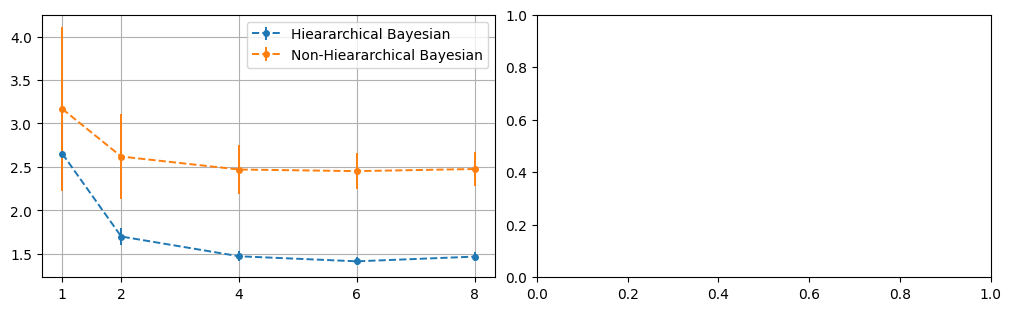

In [10]:
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=np.array(N_space[:N_LIM]), y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

ax.grid()
ax.legend()
ax.set_xticks(N_space[:N_LIM]);

# ax = axes[0, 1]
# me, sem, std = _process_bp(hbm_mu_delta)
# ax.errorbar(x=N_space[:N_LIM][1:], y=me[1:], yerr=sem[1:], marker="o", label="Hiearchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(nhbm_p_value[..., 1])
# ax.errorbar(x=N_space[:N_LIM][1:], y=me[1:], yerr=sem[1:], marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# ax.set_yticks(np.arange(0, 1.1, .1))
# ax.grid(axis="y", linestyle="--", alpha=.4)
# ax.set_xticks(N_space[:N_LIM][1:])
# ax.legend(loc="lower right")
# ax.set_xlabel("# Subjects $(N)$")
# ax.set_ylabel("Power $($β$)$")
# fig.suptitle("Precision increases power\nAveraged over 12 draws and 50 repetitions per draw\n60 Pulses, 1 Rep");

In [10]:
hbm_error.shape

(5, 8, 50, 3)

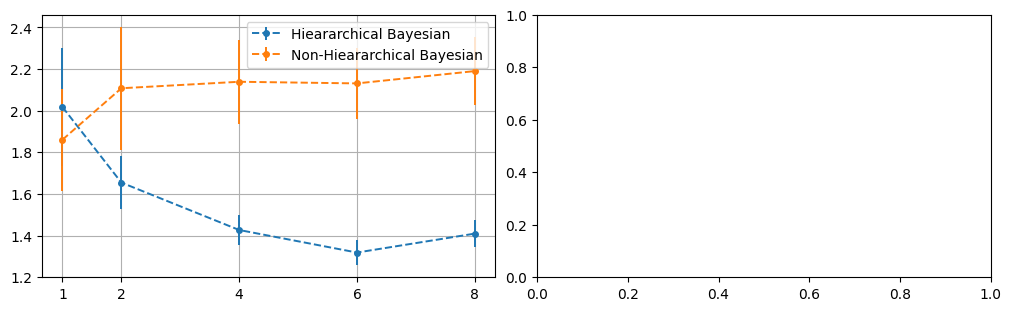

In [11]:
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=np.array(N_space[:N_LIM]), y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

ax.grid()
ax.legend()
ax.set_xticks(N_space[:N_LIM]);
